In [1]:
import os
import time
import glob
import re
import pandas as pd
from functools import reduce
from klepto.archives import dir_archive

import numpy as np
from tqdm.auto import tqdm
import coffea.processor as processor
from coffea.processor.accumulator import AccumulatorABC
from coffea.analysis_objects import JaggedCandidateArray
from coffea.btag_tools import BTagScaleFactor
from coffea import hist
import pandas as pd
import uproot_methods
import uproot
import awkward
import copy

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from Tools.config_helpers import *
from Tools.helpers import mergeArray, mt

from Tools.objects import Collections
from Tools.cutflow import Cutflow

# This just tells matplotlib not to open any
# interactive windows.
matplotlib.use('Agg')

In [2]:
#plotting aesthetics

lineopts = {
    'color': 'r',
}

data_err_opts = {
    'linestyle': 'none',
    'marker': '_',
    'markersize': 10.,
    'color': 'r',
    'elinewidth': 1,
} 

lineopts2 = {
    'color': [('#7FB069'), ('#5171A5') ,('#E2AEDD'), ('#A33B20'), ('#680E4B'), ('#F6AE2D'),('#45503B')],
}
fillopts1 = {
    'edgecolor': (0,0,0,0.3),
    'facecolor': [('#7FB069'), ('#5171A5') ,('#E2AEDD'), ('#A33B20'), ('#680E4B'), ('#F6AE2D'),('#45503B')],
    #'facecolor': [('#1467cc'), ('#51d673') ,('#f7d969'), ('#af84f0'), ('#4f842e'), ('#1ff4ff'),('#3612ab')],
}

In [3]:
def pad_and_flatten(val): 
    try:
        return val.pad(1, clip=True).fillna(0.).flatten()#.reshape(-1, 1)
    except AttributeError:
        return val.flatten()

def savefig(hists, outdir, name):
    import re
    bkgonly = re.compile('(?!mC750_l1)')
    ax = hist.plot1d(hists[bkgonly], overlay="dataset", density=False, stack=True)#, 
                #fill_opts = fillopts1, overflow = 'over')
    hist.plot1d(hists['mC750_l1'], overlay="dataset", density=False, stack=False, 
                error_opts=data_err_opts)#, overflow = 'over') 
    ax.set_yscale('log')
    ax.set_ylim(0.001,1000000)
    ax.figure.savefig(os.path.join(outdir, "{}_log.pdf".format(name)))
    ax.clear()

def savefigshape(hists, outdir, name):
    ax = hist.plot1d(hists, overlay="dataset", density=True, stack=False, 
                line_opts = lineopts2, overflow = 'over')
    
    ax.set_yscale('log')
    ax.set_ylim(0.00001,10)
    ax.figure.savefig(os.path.join(outdir, "{}_shape_log.pdf".format(name)))
    ax.clear()

#os.environ['KERAS_BACKEND'] = 'theano'
#from keras.models import load_model

In [4]:
import sys
sys.setrecursionlimit(10000)
print(sys.getrecursionlimit())

10000


In [19]:
class analysisProcessor(processor.ProcessorABC):
    """Processor used for running the analysis"""
    def __init__(self):
        
        ## load b-tag SFs
        #self.btag_sf = BTagScaleFactor(os.path.expandvars("$TWHOME/data/DeepCSV_102XSF_V1.btag.csv.gz", "reshape")

        ## load the NN
        #self.model = load_model('../ML/data/training.h5')
        #self.stds  = pd.read_json('../ML/data/stds.json').squeeze()
        #self.means = pd.read_json('../ML/data/means.json').squeeze()
        
        # we can use a large number of bins and rebin later
        dataset_axis        = hist.Cat("dataset",   "Primary dataset")
        pt_axis             = hist.Bin("pt",        r"$p_{T}$ (GeV)", 1000, 0, 1000)
        p_axis              = hist.Bin("p",         r"$p$ (GeV)", 1000, 0, 2500)
        ht_axis             = hist.Bin("ht",        r"$H_{T}$ (GeV)", 500, 0, 5000)
        mass_axis           = hist.Bin("mass",      r"M (GeV)", 1000, 0, 2000)
        eta_axis            = hist.Bin("eta",       r"$\eta$", 60, -5.5, 5.5)
        delta_axis          = hist.Bin("delta",     r"$\delta$", 100,0,10 )
        multiplicity_axis   = hist.Bin("multiplicity",         r"N", 20, -0.5, 19.5)
        norm_axis           = hist.Bin("norm",         r"N", 25, 0, 1)

        self._accumulator = processor.dict_accumulator({
            "MET_pt_baseline" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_baseline" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_baseline" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt" :          hist.Hist("Counts", dataset_axis, pt_axis),
            "HT" :              hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min" :         hist.Hist("Counts", dataset_axis, mass_axis),
            "MET_pt_CR" :       hist.Hist("Counts", dataset_axis, pt_axis),
            "HT_CR" :           hist.Hist("Counts", dataset_axis, ht_axis),
            "mtb_min_CR" :      hist.Hist("Counts", dataset_axis, mass_axis),
            "lead_AK8_pt" :     hist.Hist("Counts", dataset_axis, pt_axis),
            "W_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "H_pt" :            hist.Hist("Counts", dataset_axis, pt_axis),
            "W_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            "H_eta" :           hist.Hist("Counts", dataset_axis, eta_axis),
            
            "N_b" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK4" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_AK8" :           hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_H" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            "N_W" :             hist.Hist("Counts", dataset_axis, multiplicity_axis),
            
            "WH_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "WH_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaPhi":      hist.Hist("Counts", dataset_axis, delta_axis),
            "bb_deltaR":        hist.Hist("Counts", dataset_axis, delta_axis),
            "min_dphiJetMet4":  hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiJet":        hist.Hist("Counts", dataset_axis, delta_axis),
            "dphiDiFatJet":     hist.Hist("Counts", dataset_axis, delta_axis),
            
            'mC750_l1':         processor.defaultdict_accumulator(int),
            'WJets':            processor.defaultdict_accumulator(int),
            'QCD':              processor.defaultdict_accumulator(int),
            'TTJets':           processor.defaultdict_accumulator(int),
            'ZNuNu':            processor.defaultdict_accumulator(int),
            'ST':               processor.defaultdict_accumulator(int),
            'ttW/ttZ':          processor.defaultdict_accumulator(int),
            'WW/WZ/ZZ':         processor.defaultdict_accumulator(int),
            'LL':               processor.defaultdict_accumulator(int),
            'Data':             processor.defaultdict_accumulator(int),
            'totalEvents':      processor.defaultdict_accumulator(int),
            'test1':            processor.defaultdict_accumulator(float),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        """
        Processing function. This is where the actual analysis happens.
        """
        output = self.accumulator.identity()
        dataset = df["dataset"]
        cfg = loadConfig()
        
        ## MET -> can switch to puppi MET
        met_pt  = df["MET_pt"]
        met_phi = df["MET_phi"]
        
        ## Muons
        muon = JaggedCandidateArray.candidatesfromcounts(
            df['nMuon'],
            pt = df['Muon_pt'].content,
            eta = df['Muon_eta'].content,
            phi = df['Muon_phi'].content,
            mass = df['Muon_mass'].content,
            miniPFRelIso_all=df['Muon_miniPFRelIso_all'].content,
            looseId =df['Muon_looseId'].content
            )
        muon = muon[(muon.pt > 10) & (abs(muon.eta) < 2.4) & (muon.looseId) & (muon.miniPFRelIso_all < 0.2)]
        #muon = Collections(df, "Muon", "tightTTH").get() # this needs a fix for DASK
        
        electrons = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt=df['Electron_pt'].content, 
            eta=df['Electron_eta'].content, 
            phi=df['Electron_phi'].content,
            mass=df['Electron_mass'].content,
            pdgid=df['Electron_pdgId'].content,
            mini_iso=df['Electron_miniPFRelIso_all'].content
        )
        
        ## Electrons
        electron = JaggedCandidateArray.candidatesfromcounts(
            df['nElectron'],
            pt = df['Electron_pt'].content,
            eta = df['Electron_eta'].content,
            phi = df['Electron_phi'].content,
            mass = df['Electron_mass'].content,
            miniPFRelIso_all=df['Electron_miniPFRelIso_all'].content,
            cutBased=df['Electron_cutBased'].content
            )
        electron = electron[(electron.pt>10) & (abs(electron.eta) < 2.4) & (electron.miniPFRelIso_all < 0.1) &  (electron.cutBased >= 1)]
        #electron = Collections(df, "Electron", "tightTTH").get() # this needs a fix for DASK
        
        ## FatJets
        fatjet = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt = df['FatJet_pt'].content,
            eta = df['FatJet_eta'].content,
            phi = df['FatJet_phi'].content,
            mass = df['FatJet_mass'].content,
            msoftdrop = df["FatJet_msoftdrop"].content,  
            deepTagMD_HbbvsQCD = df['FatJet_deepTagMD_HbbvsQCD'].content, 
            deepTagMD_WvsQCD = df['FatJet_deepTagMD_WvsQCD'].content, 
            deepTag_WvsQCD = df['FatJet_deepTag_WvsQCD'].content
            
        )
        
        leadingFatJets = fatjet[:,:2]
        difatjet = leadingFatJets.choose(2)
        dphiDiFatJet = np.arccos(np.cos(difatjet.i0.phi-difatjet.i1.phi))
        
        htag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        htag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD > 0.8365))]
        
        lead_htag = htag[htag.pt.argmax()]
        
        wtag = fatjet[((fatjet.pt > 200) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        wtag_hard = fatjet[((fatjet.pt > 300) & (fatjet.deepTagMD_HbbvsQCD < 0.8365) & (fatjet.deepTag_WvsQCD > 0.918))]
        
        lead_wtag = wtag[wtag.pt.argmax()]
        
        wh = lead_htag.cross(lead_wtag)
        wh_deltaPhi = np.arccos(wh.i0.phi - wh.i1.phi)
        wh_deltaR = wh.i0.p4.delta_r(wh.i1.p4)
        
        ## Jets
        jet = JaggedCandidateArray.candidatesfromcounts(
            df['nJet'],
            pt = df['Jet_pt'].content,
            eta = df['Jet_eta'].content,
            phi = df['Jet_phi'].content,
            mass = df['Jet_mass'].content,
            jetId = df['Jet_jetId'].content, # https://twiki.cern.ch/twiki/bin/view/CMS/JetID
            #puId = df['Jet_puId'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/PileupJetID
            btagDeepB = df['Jet_btagDeepB'].content, # https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation102X
            #deepJet = df['Jet_'].content # not there yet?
        )
        
        jet       = jet[(jet.pt>30) & (jet.jetId>1) & (abs(jet.eta)<2.4)]
        jet       = jet[~jet.match(muon, deltaRCut=0.4)] # remove jets that overlap with muons
        jet       = jet[~jet.match(electron, deltaRCut=0.4)] # remove jets that overlap with electrons
        jet       = jet[jet.pt.argsort(ascending=False)] # sort the jets
        btag      = jet[(jet.btagDeepB>0.4184)]
        light     = jet[(jet.btagDeepB<0.4184)]
        
        ## Get the leading b-jets
        high_score_btag = jet[jet.btagDeepB.argsort(ascending=False)][:,:2]
        
        leading_jet    = jet[jet.pt.argmax()]
        leading_b      = btag[btag.pt.argmax()]
        
        bb = high_score_btag.choose(2)
        bb_deltaPhi = np.arccos(np.cos(bb.i0.phi-bb.i1.phi))
        bb_deltaR = bb.i0.p4.delta_r(bb.i1.p4)
        
        mtb = mt(btag.pt, btag.phi, met_pt, met_phi)
        min_mtb = mtb.min()
        
        ## other variables
        ht = jet.pt.sum()
        
        min_dphiJetMet4 = np.arccos(np.cos(jet[:,:4].phi-met_phi)).min()
        
        leadingJets = jet[:,:2]
        dijet = leadingJets.choose(2)
        dphiDiJet = np.arccos(np.cos(dijet.i0.phi-dijet.i1.phi))
        
        ## define selections (maybe move to a different file at some point)
        
        output['totalEvents']['all'] += len(df['weight'])
        
        # Cutflow
        #processes = ['mC750_l1', 'WJets', 'QCD', 'TTJets', 'ZNuNu', 'ST', 'ttW/ttZ', 'WW/WZ/ZZ']
        processes = ['mC750_l1', 'LL', 'QCD', 'ZNuNu', 'Data']
        weight = np.ones(len(df['weight'])) if dataset=='Data' else df['weight']
        lumi = 1 if dataset=='Data' else 60
        cutflow = Cutflow(output, df, lumi, processes, weight=weight)


        cutflow.addRow( 'Exactly 1 e or mu',   ((electron.counts + muon.counts)==1) )
        #cutflow.addRow( 'muon veto',   (muon.counts==0) )
        #cutflow.addRow( 'MET>250',     (met_pt>250) )
        cutflow.addRow( 'MET>250',     (met_pt>250) )
        cutflow.addRow( 'MET>400',     (met_pt>400) )
        cutflow.addRow( 'MET>600',     (met_pt>600) )
        cutflow.addRow( 'njet2',       (jet.counts>=2) )
        cutflow.addRow( 'jetveto',       (jet.counts<=5) )
        cutflow.addRow( 'nbtag',       (btag.counts>=1) )
        
        baseline = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'min_mt_met_b>200', (min_mtb>200)  )
        cutflow.addRow( 'min_dphiJetMet4', (min_dphiJetMet4>0.5))
        cutflow.addRow( 'dphiDiJet', (dphiDiJet.min()<2.5) ) # the min doesn't do anything here
        cutflow.addRow( 'dphiDiFatJet', (dphiDiFatJet<2.5).all() ) # by using .all() I do not implicitely cut on the number of fat jets
        
        vetoQCD = copy.deepcopy(cutflow.selection)
        
        cutflow.addRow( 'HT>300',      (ht>300) )
        cutflow.addRow( 'N_fatjet>0',      (fatjet.counts>0) )
        cutflow.addRow( 'N_htag>0',     (htag.counts>0))
        cutflow.addRow( 'H_mass>90',     ((lead_htag.msoftdrop>90).any()))
        cutflow.addRow( 'H_mass<150',     ((lead_htag.msoftdrop<150).any()))
        cutflow.addRow( 'N_fatjet>1',      (fatjet.counts>1) )
        cutflow.addRow( 'N_wtag>0',     (wtag.counts>0))
        
        event_selection = copy.deepcopy(cutflow.selection)
        
        #cutflow.addRow( 'N_htag>0 hard',     (htag_hard.counts>0))

        # signal enriched selection of events
        signal_selection = cutflow.selection
        
        ### And fill the histograms
        output['MET_pt_baseline'].fill(dataset=dataset, pt=met_pt[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['HT_baseline'].fill(dataset=dataset, ht=ht[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['mtb_min_baseline'].fill(dataset=dataset, mass=mtb[baseline].min().flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        output['MET_pt'].fill(dataset=dataset, pt=met_pt[vetoQCD].flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        output['HT'].fill(dataset=dataset, ht=ht[vetoQCD].flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        output['mtb_min'].fill(dataset=dataset, mass=mtb[vetoQCD].min().flatten(), weight=df['weight'][vetoQCD]*cfg['lumi'])
        
        ## N jet and N b without selections on those
        output['N_AK4'].fill(dataset=dataset, multiplicity=jet[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])
        output['N_b'].fill(dataset=dataset, multiplicity=btag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_W'].fill(dataset=dataset, multiplicity=htag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_H'].fill(dataset=dataset, multiplicity=wtag[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       
        output['N_AK8'].fill(dataset=dataset, multiplicity=fatjet[baseline].counts, weight=df['weight'][baseline]*cfg['lumi'])       

        output['bb_deltaPhi'].fill(dataset=dataset, delta=bb_deltaPhi[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['bb_deltaR'].fill(dataset=dataset, delta=bb_deltaR[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        output['min_dphiJetMet4'].fill(dataset=dataset, delta=min_dphiJetMet4[baseline].flatten(), weight=df['weight'][baseline]*cfg['lumi'])
        output['dphiDiJet'].fill(dataset=dataset, delta=dphiDiJet[baseline].min().flatten(), weight=df['weight'][baseline]*cfg['lumi'])

        ## Higgs and W pt
        output['lead_AK8_pt'].fill(dataset=dataset, pt=fatjet[(baseline & (fatjet.counts>0))].pt.max().flatten(), weight=df['weight'][(baseline & (fatjet.counts>0))]*cfg['lumi'])
        output['dphiDiFatJet'].fill(dataset=dataset, delta=dphiDiFatJet[(baseline & (fatjet.counts>1))].min().flatten(), weight=df['weight'][(baseline & (fatjet.counts>1))]*cfg['lumi'])

        output['H_pt'].fill(dataset=dataset, pt=lead_htag[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['H_eta'].fill(dataset=dataset, eta=lead_htag[event_selection].eta.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['W_pt'].fill(dataset=dataset, pt=lead_wtag[event_selection].pt.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['W_eta'].fill(dataset=dataset, eta=lead_wtag[event_selection].eta.flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['WH_deltaPhi'].fill(dataset=dataset, delta=wh_deltaPhi[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['WH_deltaR'].fill(dataset=dataset, delta=wh_deltaR[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])

        output['MET_pt_CR'].fill(dataset=dataset, pt=met_pt[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['HT_CR'].fill(dataset=dataset, ht=ht[event_selection].flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        output['mtb_min_CR'].fill(dataset=dataset, mass=mtb[event_selection].min().flatten(), weight=df['weight'][event_selection]*cfg['lumi'])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [20]:
runLocal = True


if not runLocal:
    # Get the scheduler from the dask_cluster notebook
    from dask.distributed import Client, progress

    c = Client('tcp://169.228.130.5:27879')

    ## for dask
    exe_args = {
        'client': c,
        #'savemetrics': True,
    }
    exe = processor.dask_executor
    
else:
    ## for local
    exe_args = {
        'workers': 4,
        'function_args': {'flatten': False}
    }
    exe = processor.futures_executor

if not runLocal:
    print(c)

In [21]:
overwrite = True
small = False

tag = '0p1p20'
#tag = '0p1p16/2018'

fileset_WH   = {'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                'WJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WJetsToLNu*/*.root'),
                'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/QCD_HT*/*.root'),
                'TTJets': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/TTJets*/*.root'),
                'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZJetsToNuNu*/*.root'),
                'ST': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ST*/*.root'),
                'ttW/ttZ': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttWJets*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttZJets*/*.root'),
                'WW/WZ/ZZ': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WW*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WZ*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2L2Nu*/*.root')
                    +glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2Q2Nu*/*.root')
                }

fileset_WH_merge = {'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                'LL': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WJetsToLNu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/TTJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ST*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttWJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WW*/*.root'),
                'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/QCD_HT*/*.root'),
                'ZNuNu': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZJetsToNuNu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttZJets*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WZ*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2L2Nu*/*.root')
                    + glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ZZTo2Q2Nu*/*.root'),
                'Data': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/0p1p24/MET_Run2018*/*.root')

                }


# load the config and the cache
cfg = loadConfig()

cacheName = 'WH_small' if small else 'WH'

# histograms
histograms = []
histograms += ['N_AK4']

# initialize cache
cache = dir_archive(os.path.join(os.path.expandvars(cfg['caches']['base']), cfg['caches'][cacheName]), serialized=True)
if not overwrite:
    cache.load()

if cfg == cache.get('cfg') and histograms == cache.get('histograms') and cache.get('simple_output'):
    output = cache.get('simple_output')

else:
    # Run the processor
    if small:
        fileset = {
                    'mC750_l1': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/WH_had_750_1_nanoAOD/*.root'),
                    'LL': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/ttWJets*/*.root')[:2],
                    'QCD': glob.glob('/hadoop/cms/store/user/ksalyer/allHadTest/'+tag+'/QCD_HT*/*.root')[:2]}
        workers = 4
    else:
        fileset = fileset_WH_merge
        workers = 16
    
        
    output = processor.run_uproot_job(fileset,
                                      treename='Events',
                                      processor_instance=analysisProcessor(),
                                      executor=exe,
                                      executor_args=exe_args,
                                      #chunksize=250000,
                                      chunksize=100000,
                                     )
    cache['fileset']        = fileset
    cache['cfg']            = cfg
    cache['histograms']     = histograms
    cache['simple_output']  = output
    cache.dump()

HBox(children=(HTML(value='Processing'), FloatProgress(value=0.0, max=614.0), HTML(value='')))

/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [22]:
# Cutflow
from Tools.helpers import getCutFlowTable

#processes = ['mC750_l1', 'WJets', 'QCD', 'TTJets', 'ZNuNu', 'ST', 'ttW/ttZ', 'WW/WZ/ZZ']
processes = ['mC750_l1', 'LL', 'QCD', 'ZNuNu','Data']
lines     = ['entry']
lines    += ['Exactly 1 e or mu', 'MET>250', 'MET>400', 'MET>600', 'njet2', 'jetveto', 'nbtag',  'HT>300', 'min_mt_met_b>200', 'min_dphiJetMet4', 'dphiDiJet', 'dphiDiFatJet', 'N_fatjet>0', 'N_htag>0',  'H_mass>90', 'H_mass<150', 'N_fatjet>1', 'N_wtag>0']
df        = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='mC750_l1')
df

,mC750_l1,LL,QCD,ZNuNu,Data,S/B
entry,130.5 +/- 0.6,3391000.0 +/- 8000.0,1712000.0 +/- 12000.0,792000.0 +/- 400.0,9995000.0 +/- 3000.0,0.0000
Exactly 1 e or mu,2.075 +/- 0.078,1612000.0 +/- 5000.0,327300.0 +/- 9700.0,14150.0 +/- 60.0,1256000.0 +/- 1000.0,0.0000
MET>250,1.873 +/- 0.074,684400.0 +/- 3600.0,194200.0 +/- 7600.0,7007.0 +/- 43.0,496200.0 +/- 700.0,0.0000
MET>400,1.187 +/- 0.059,99790.0 +/- 1390.0,61590.0 +/- 4240.0,1309.0 +/- 18.0,55030.0 +/- 230.0,0.0000
MET>600,0.405 +/- 0.035,15690.0 +/- 560.0,22870.0 +/- 2490.0,237.5 +/- 7.6,7022.0 +/- 84.0,0.0000
njet2,0.391 +/- 0.034,12440.0 +/- 480.0,18170.0 +/- 2190.0,180.6 +/- 6.5,5452.0 +/- 74.0,0.0000
jetveto,0.355 +/- 0.032,11820.0 +/- 480.0,17870.0 +/- 2180.0,173.4 +/- 6.4,5044.0 +/- 71.0,0.0000
nbtag,0.243 +/- 0.027,1746.0 +/- 163.0,1811.0 +/- 630.0,26.78 +/- 2.18,937.0 +/- 30.6,0.0001
HT>300,0.204 +/- 0.025,964.2 +/- 150.0,18.33 +/- 8.58,15.75 +/- 1.61,367.0 +/- 19.2,0.0001
min_mt_met_b>200,0.228 +/- 0.026,1373.0 +/- 163.0,1165.0 +/- 512.0,20.49 +/- 1.97,612.0 +/- 24.7,0.0001


In [23]:
# Efficiencies
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=3, absolute=False)
df

,mC750_l1,LL,QCD,ZNuNu,Data
entry,1.000,1.000,1.000,1.000,1.000
Exactly 1 e or mu,0.016,0.475,0.191,0.018,0.126
MET>250,0.903,0.425,0.593,0.495,0.395
MET>400,0.633,0.146,0.317,0.187,0.111
MET>600,0.342,0.157,0.371,0.181,0.128
njet2,0.964,0.793,0.794,0.760,0.776
jetveto,0.909,0.950,0.984,0.960,0.925
nbtag,0.683,0.148,0.101,0.154,0.186
HT>300,0.841,0.552,0.010,0.588,0.392
min_mt_met_b>200,1.116,1.423,63.589,1.301,1.668


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


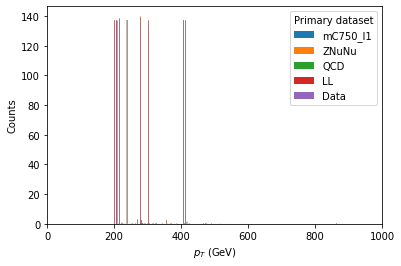

In [10]:
#show/save histograms
histogram = output['MET_pt_CR']
ax = hist.plot1d(histogram,overlay="dataset", stack=True)
new_met_bins = hist.Bin('pt', r'MET', 50, 200, 1000)
histogram = histogram.rebin('pt', new_met_bins)

#plt.savefig('plots/singleLep_CR/MET_pt_CR.pdf')

In [11]:
#desired histograms to save
histograms = ["MET_pt_CR",
              "H_pt",
              "H_eta",
              "W_pt",
              "W_eta",
              #"ht", 
              #"jet_pt", 
              #"njets", 
              #"bjets",
             ]

outdir = "/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/plots/singleLeptonCR/"

MET_pt_CR


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


H_pt


/home/users/ksalyer/CMSSW_10_2_9/src/tW_scattering/coffeaEnv/lib/python3.6/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


H_eta


ValueError: Axis <Bin (name=eta) instance at 0x7f6188597160> has no interval that fully contains identifier <Interval ([-4.03333333333, -3.85)) instance at 0x7f6188197160>

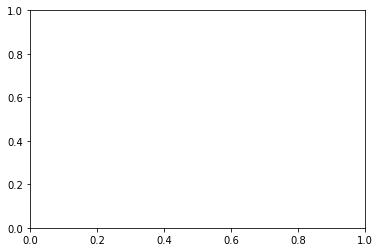

In [12]:
for name in histograms:
    print (name)
    hists = output[name]
    
    if name == "MET_pt_CR":
        new_met_bins = hist.Bin('pt', r'$p_{T}^{missing}$', 50, 200, 1000)
        hists = hists.rebin('pt', new_met_bins)
    
    if name == "H_pt":
        new_pt_bins = hist.Bin('pt', r'Higgs $p_{T}$', 50, 200, 1000)
        hists = hists.rebin('pt', new_pt_bins)
    
    if name == "H_eta":
        new_eta_bins = hist.Bin('eta', r'Higgs $\eta$', 20, -4, 4)
        hists = hists.rebin('eta', new_eta_bins)
    
    if name == "W_pt":
        new_pt_bins = hist.Bin('pt', r'W $p_{T}$', 50, 200, 1000)
        hists = hists.rebin('pt', new_pt_bins)
    
    if name == "W_eta":
        new_eta_bins = hist.Bin('eta', r'W $\eta$', 20, -4, 4)
        hists = hists.rebin('eta', new_eta_bins)
        
    '''if name == "ht":
        new_ht_bins = hist.Bin('pt', r'HT', 25, 300, 2000)
        hists = hists.rebin('pt', new_ht_bins)
        
    if name == "jet_pt":
        new_jetpt_bins = hist.Bin('pt', r'jet $p_{T}$', 25, 300, 2000)
        hists = hists.rebin('pt', new_jetpt_bins)
        
    if name == "njets":
        new_nj_bins = hist.Bin('multiplicity', r'nJets', 16, -0.5, 15.5)
        hists = hists.rebin('multiplicity', new_nj_bins)
        
    if name == "bjets":
        new_bj_bins = hist.Bin('multiplicity', r'nBJets', 7, -0.5, 6.5)
        hists = hists.rebin('multiplicity', new_bj_bins)
    '''
        
    savefig(hists,outdir, name)
    #savefigshape(hists,outdir, name)